# Встановлення залежностей

In [119]:
!pip install wfdb
!pip install py-ecg-detectors
!pip install sklearn
!pip install gensim
!pip install -U scikit-learn

In [120]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Завантаження даних ЕКГ

In [121]:
if os.path.isdir("mitdb"):
    print('You already have the data.')
else:
    wfdb.dl_database('mitdb', 'mitdb')

You already have the data.


In [122]:
record = record = wfdb.rdsamp('mitdb/100', sampto=500000)
record[1]
# record[0][:,0]
#annotation = wfdb.rdann('mitdb/100','atr', sampfrom=50)
# record[1]
# record[0][:,0]
#sample = annotation.__dict__
#sample

{'fs': 360,
 'sig_len': 500000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}

# Виділення R піків

In [123]:
from ecgdetectors import Detectors
fs = 250
detectors = Detectors(fs)
unfiltered_ecg = record[0][:, 1]
r_peaks = detectors.engzee_detector(unfiltered_ecg)
# Amendment for first peak
r_peaks[0] += 20

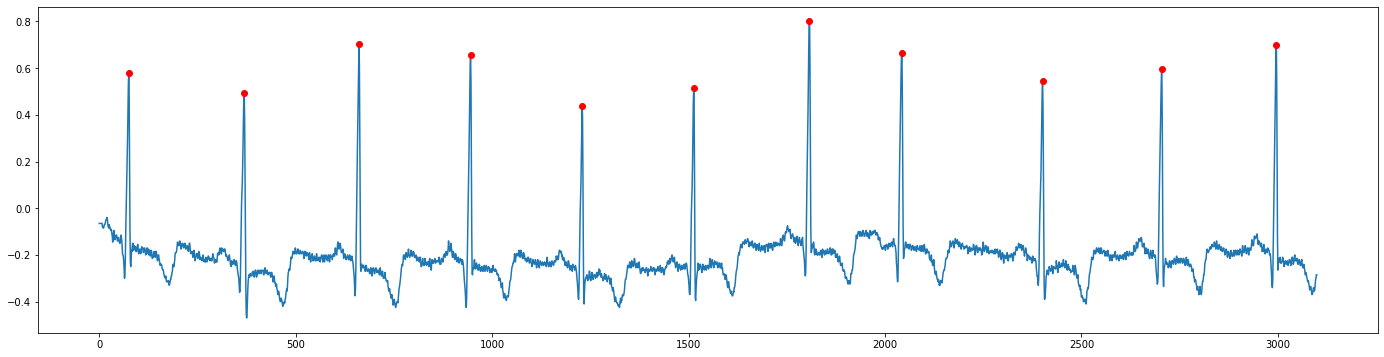

In [124]:
r_peaks_split = r_peaks[:11]
plt.figure(figsize=(24,6))
plt.plot(unfiltered_ecg[:3100])
plt.plot(r_peaks_split, unfiltered_ecg[r_peaks_split], 'ro')
plt.show()

# Розподіл ЕКГ сигналу на серцебиття

In [125]:
# Find heartbeat lenght
distances = []
for i in range(len(r_peaks)):
  if i + 1 < len(r_peaks):
    distances.append(r_peaks[i + 1] - r_peaks[i])
distances = np.array(distances)
heart_beat_len = int(distances.mean())
heart_beat_len

286

In [126]:
# Beat EGC signal
beats = []
for i in range(len(r_peaks)):
  if i != 0 :
    r_index = r_peaks[i]
    retreat = heart_beat_len // 2
    beats.append(unfiltered_ecg[r_index - retreat:r_index + retreat])
len(beats)

1743

# Візуалізація серцебиттів

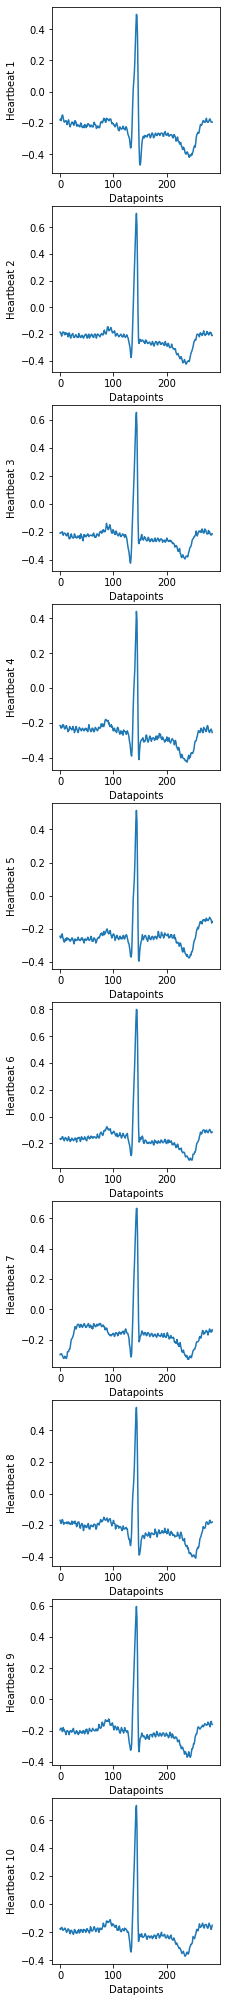

In [127]:
ig, ax = plt.subplots(nrows=10, figsize=(3,36))
plots = []
for beat in beats:
  plots.append(beat)



i = 0 
for plot in plots:
  if i < 10:
    ax[i].plot(plot)
    ax[i].set_ylabel('Heartbeat {}'.format(i + 1))
    ax[i].set_xlabel('Datapoints')
  i += 1

# Виділення хвиль в кожному серцебитті

In [128]:
p_waves = []
qrs_waves = []
t_waves = []
for j in range(len(beats)):
  if j + 1 != len(beats):
    p_waves.append(beats[j][:retreat - 15])
    qrs_waves.append(beats[j][retreat - 15:retreat + 15])
    t_waves.append(beats[j][retreat + 15:])

print(len(t_waves[0]))
print(len(p_waves))

128
1742


# Кластеризація виділених хвиль


In [129]:
# P and T waves clustering (20 clusters)
from sklearn.cluster import KMeans
pt_waves = np.array(p_waves + t_waves)
print(pt_waves.shape)
kmeans = KMeans(init='k-means++', n_clusters=300, n_init=10)
kmeans.fit(pt_waves)
predict_pt = kmeans.predict(pt_waves)
predict_pt.shape

(3484, 128)


(3484,)

In [130]:
# QRS waves clustering (6 clusters)
qrs_waves = np.array(qrs_waves)
kmeans_1 = KMeans(init='k-means++', n_clusters=40, n_init=10)
kmeans_1.fit(qrs_waves)
predict_qrs = kmeans_1.predict(qrs_waves)
predict_qrs.shape

(1742,)

# Присвоювання символів хвилі кожного кластеру

In [131]:
alphabet_for_pt = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'g', 7:'h', 8:'i',
                   9:'j', 10:'k', 11:'l', 12:'m', 13:'n', 14:'o', 15:'p', 16:'q', 17:'r',
                   18:'s', 19:'t'}
alphabet_for_qrs = {0:'u', 1:'v', 2:'w', 3:'x', 4:'y', 5:'z'}

def get_symbol_pt(x):
  return alphabet_for_pt[x]

def get_symbol_qrs(x):
  return alphabet_for_qrs[x]

vfunc = np.vectorize(get_symbol_pt)
vfunc_2 = np.vectorize(get_symbol_qrs)

# predict_pt_letters = vfunc(predict_pt)
# predict_qrs_letters = vfunc_2(predict_qrs)


In [132]:
#len(predict_qrs_letters)

In [133]:
# words = []
# for i in range(len(predict_qrs_letters)):
#   word = ''
#   word += predict_pt_letters[i]
#   word += predict_qrs_letters[i]
#   word += predict_pt_letters[i + len(predict_qrs_letters)//2]
#   words.append(word)
#
# words

# Word2Vec model

In [134]:
# from gensim.models import Word2Vec
# word2vec = Word2Vec([words,], min_count=0)

In [135]:
# vocabulary = word2vec.wv.key_to_index
# vocabulary

In [136]:
#sim = word2vec.wv.most_similar('jwl')
#sim

In [137]:
#word2vec.wv['jwl']

In [138]:
# from sklearn.datasets import make_blobs
# X, y_true = make_blobs(n_samples=300, centers=4,
#                        cluster_std=0.60, random_state=0)
# from sklearn.cluster import KMeans
# kmeansS = KMeans(n_clusters=4)
# kmeansS.fit(X)
# kmeansS.cluster_centers_.shape
#
# np.matrix([1, 2, 3])


In [139]:
reversed_alphabet_for_pt = {}
for k,v in alphabet_for_pt.items():
  reversed_alphabet_for_pt[v] = k

reversed_alphabet_for_qrs = {}
for k,v in alphabet_for_qrs.items():
  reversed_alphabet_for_qrs[v] = k

pr_centers = kmeans.cluster_centers_
qrs_centers = kmeans_1.cluster_centers_
# KMeans Original data: 3484x128
print("pr_centers.shape:")
print(pr_centers.shape)
print("qrs_centers.shape:")
print(qrs_centers.shape)

def get_pr_from_symbol(x):
  return  pr_centers[x]

def get_qrs_from_symbol(x):
  return qrs_centers[x]

reverse_vfunc = np.vectorize(get_pr_from_symbol, signature='()->(n)')
reverse_vfunc_2 = np.vectorize(get_qrs_from_symbol, signature='()->(n)')

predict_pt_original = reverse_vfunc(predict_pt)
predict_qrs_original = reverse_vfunc_2(predict_qrs)
print("predict_pt_original.shape:")
print(predict_pt_original.shape)
print("predict_qrs_original.shape:")
print(predict_qrs_original.shape)

splited_pt = np.split(predict_pt_original, 2)
predict_t_original = splited_pt[0]
predict_p_original = splited_pt[1]
print(str(predict_pt_original.shape) + " = " + str(predict_t_original.shape) + " + " + str(predict_p_original.shape))

restored_beats = np.concatenate((predict_t_original, predict_qrs_original, predict_p_original), axis=1)
print("restored_beats.shape = " + str(restored_beats.shape))

pr_centers.shape:
(300, 128)
qrs_centers.shape:
(40, 30)
predict_pt_original.shape:
(3484, 128)
predict_qrs_original.shape:
(1742, 30)
(3484, 128) = (1742, 128) + (1742, 128)
restored_beats.shape = (1742, 286)


Original:
(286,)
Restored:
(286,)


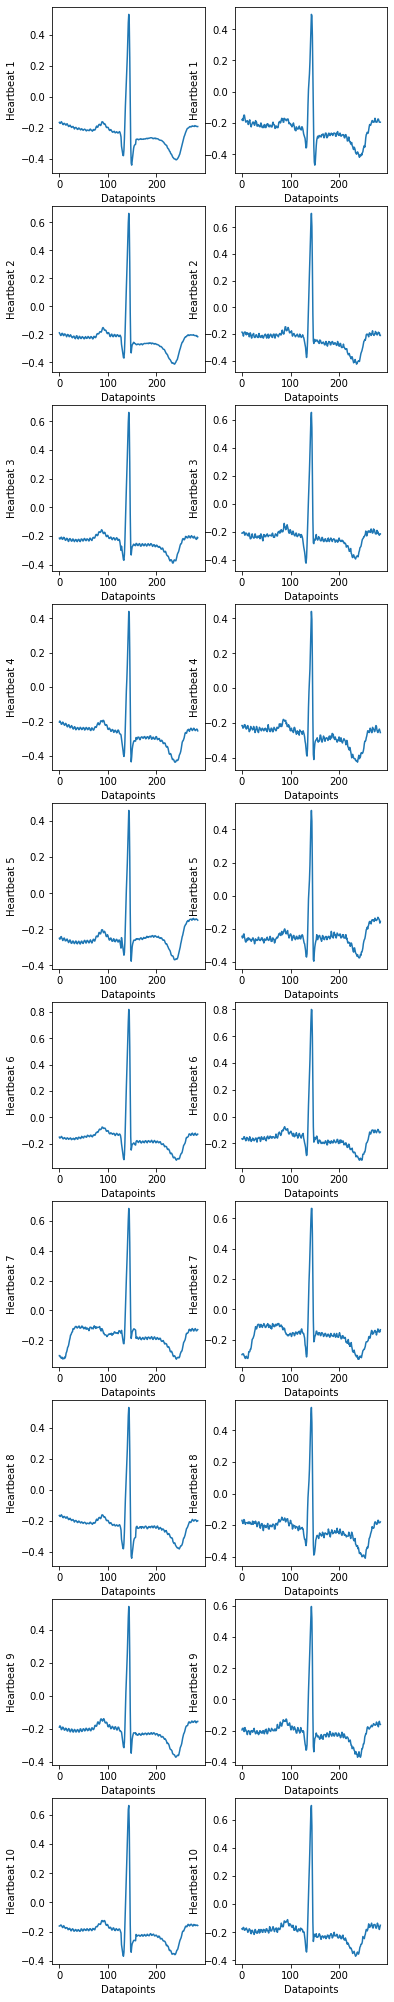

In [140]:
print("Original:")
print(beats[0].shape)
print("Restored:")
print(restored_beats[0].shape)

fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(6,36))
restored_plots = []
for beat in restored_beats:
  restored_plots.append(beat)

original_plots = []
for beat in beats:
  original_plots.append(beat)

for i in range(10):
  ax1 = ax[i][0]
  ax2 = ax[i][1]
  ax1.plot(restored_plots[i])
  ax1.set_ylabel('Heartbeat {}'.format(i + 1))
  ax1.set_xlabel('Datapoints')

  ax2.plot(original_plots[i])
  ax2.set_ylabel('Heartbeat {}'.format(i + 1))
  ax2.set_xlabel('Datapoints')

plt.savefig("comparing.png", transparent=False)

In [141]:
from sklearn.metrics import mean_absolute_error
for i in range(10):
  rmspe = np.sqrt(np.mean(np.square(((beats[i] - restored_beats[i]) / beats[i])), axis=0))
  print(rmspe)


# len(words)
# len(vocabulary)
# kmeans.cluster_centers_.shape
# kmeans_1.cluster_centers_.shape
# #kmeans.score(predict_pt)
# predict_pt
# #kmeans.cluster_centers_[0]


0.12725998119792076
0.0610944822211306
0.07982190868091349
0.06381352382292836
0.14787186456870807
0.12275355966119299
0.13884354939188542
0.12220812267319071
0.07771488538093568
0.1013671260264234


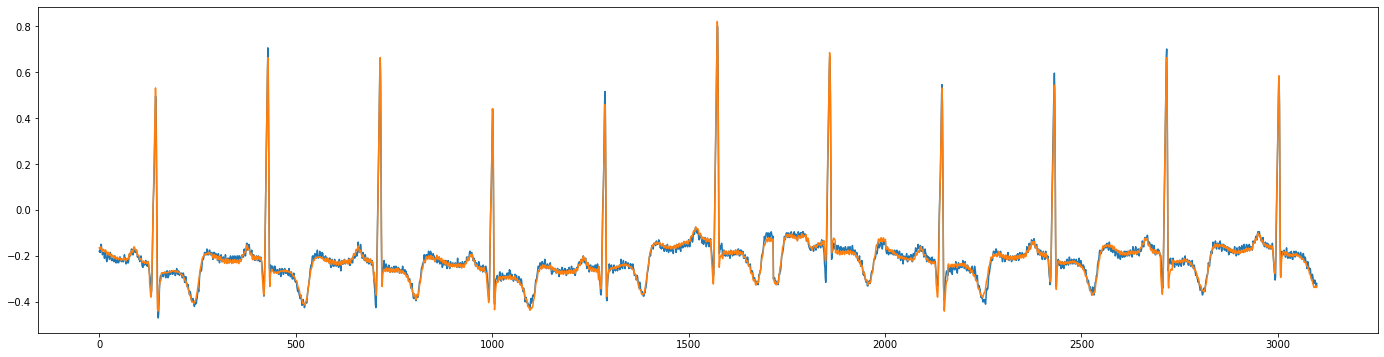

In [149]:
r_peaks_split = r_peaks[:11]
plt.figure(figsize=(24,6))
original_full = np.concatenate(beats)[:3100]
plt.plot(original_full)
restored_full = np.concatenate(restored_beats)[:3100]
plt.plot(restored_full)
plt.savefig("comparing_original.png", transparent=False)

In [150]:
#np.sqrt(np.mean(np.square(((original_full - restored_full) / original_full)), axis=0))

0.10942713553224286

In [ ]:
from sklearn.cluster import KMeans

# Returns (p_waves, qrs_waves, t_waves)
def split_waves(beats_list, retreat_value):
  c_p_waves = []
  c_qrs_waves = []
  c_t_waves = []
  for j in range(len(beats_list)):
    if j + 1 != len(beats_list):
      c_p_waves.append(beats_list[j][:retreat_value - 15])
      c_qrs_waves.append(beats_list[j][retreat_value - 15:retreat_value + 15])
      c_t_waves.append(beats_list[j][retreat_value + 15:])
  return c_p_waves, c_qrs_waves, c_t_waves

# Returns (kmeans, predicted)
def calculate_kmeans(waves, n_clusters, n_init):
  c_kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=n_init)
  c_kmeans.fit(waves)
  c_predicted = kmeans.predict(pt_waves)
  return c_kmeans, c_predicted

# Returns list original values (values of cluster centers)
# predicted - list of clusters indices
def reverse_kmeans(predicted, c_kmeans):
  cluster_centers = c_kmeans.cluster_centers_
  def get_mean_of_cluster(x):
    return cluster_centers[x]

  reverse_func = np.vectorize(get_mean_of_cluster, signature='()->(n)')
  return reverse_func(predicted)

def draw_two_waves(wave1, wave2, img_name):
  plt.figure(figsize=(24,6))
  plt.plot(wave1)
  plt.plot(wave2)
  plt.savefig(img_name, transparent=False)

def calculate_mse_percent(beats_list, retreat_value, peaks_clusters_count, pt_clusters_count):
  (c_p_waves, c_qrs_waves, c_t_waves) = split_waves(beats_list, retreat_value)
  qrs_kmeans, qrs_predicted = calculate_kmeans(c_qrs_waves, peaks_clusters_count, peaks_clusters_count // 2)
  c_pt_waves = np.array(c_p_waves + c_t_waves)
  pt_kmeans, pt_predicted = calculate_kmeans(c_pt_waves, pt_clusters_count, pt_clusters_count // 2)

  restored_qrs_original = reverse_kmeans(qrs_predicted, qrs_kmeans)
  restored_pt_original = reverse_kmeans(pt_predicted, pt_kmeans)

  split = np.split(restored_pt_original, 2)
  restored_t_original = split[0]
  restored_p_original = split[1]

  restored_original_beats = np.concatenate((restored_t_original, restored_qrs_original, restored_p_original), axis=1)[:3100]
  original_concatenated_beats = np.concatenate(beats_list)[:3100]
  draw_two_waves(restored_original_beats, original_concatenated_beats, "test_"+str(peaks_clusters_count)+"peaksClusters_" + str(pt_clusters_count) + "ptClusters")
  return np.sqrt(np.mean(np.square(((original_concatenated_beats - restored_original_beats) / original_concatenated_beats)), axis=0))

calculate_mse_percent(beats, retreat, 300, 50)